# Imports

In [128]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import qr

In [129]:
# Versions
import qiskit
import qiskit_algorithms

print(f"Qiskit version {qiskit.__version__}")
print(f"Qiskit algorithms version {qiskit_algorithms.__version__}")


# Quantum Circuits!
from qiskit import QuantumCircuit

# General Imports
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, Pauli, DensityMatrix
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_dynamics import Solver

# Noisy simulations
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    thermal_relaxation_error,
    amplitude_damping_error
)

# Running on a real quantum computer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2

# Run time-evolution problems
from qiskit_algorithms.time_evolvers import TrotterQRTE, TimeEvolutionProblem

Qiskit version 1.3.2
Qiskit algorithms version 0.3.1


## Helper Functions

### Probabilities from Statevectors

Getting and plotting probabilities from Qiskit's `Statevector` class.

In [130]:
def get_probabilities(ss: list[Statevector]) -> list[list[float]]:
    """
        Given a list of statevectors, return their probabilities organized by measurement outcome, in order.
    """
    
    # Infer number of qubits
    N = ss[0].num_qubits
    if N == None:
        raise ValueError("Invalid statevector")

    # Get the probabilities
    pp = [item.probabilities_dict() for item in ss]

    # Organize them by index
    pp_index = [[] for _ in range(2**N)]
    for prob in pp:
        for key in range(2**N):
            pp_index[key] += [prob.get(f"{bin(key)[2:]:0>{N}}", 0)]
    
    return pp_index

In [226]:
def plot_probabilities(tt: list[float | int], pp: list[list[float]], N: int, title: str, prob_minimum: float = 1e-3, xlabel: str = "Time", important: list[str] | None = None) -> None:
    """
        Plot the probabilities `pp` over time `tt` for a system of `N` qubits.
    """

    # Set to true if some probabilities where hiden
    hide_probabilities = False

    # Which strings were ploted
    ploted = important if important else []

    plt.title(title)
    for index, item in enumerate(pp):
        # Plot all important states, if specified
        bitstring = f"{bin(index)[2:]:0>{N}}"
        if important:
            if bitstring in important:
                plt.plot(tt, item, label=f"Prob. of Measuring {bitstring}")
            else:
                continue
            
        else:
            # Do not plot very low probabilities
            if np.max(item) < prob_minimum:
                hide_probabilities = True
                continue
            
            ploted += [bitstring]
            plt.plot(tt, item, label=f"Prob. of Measuring {bitstring}")

    plt.xlabel(xlabel)
    plt.ylabel("Probability")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.ylim(-0.1, 1.1)
    plt.grid()
    plt.show()

    if hide_probabilities:
        print("Measurement outcomes not shown have approximately zero probability of being seen.\n")
    

    # Check if probabilities overlap, and warn the user
    
    # Probabilities already checked (formally, already in some equivalence class)
    checked = []
    for index1, item1 in enumerate(pp):
        bitstring1 = f"{bin(index1)[2:]:0>{N}}"
        if bitstring1 not in ploted:
            continue

        for index2, item2 in enumerate(pp[index1+1:]):
            index2 = index1+1 + index2
            
            if index2 in checked:
                continue

            if np.allclose(item1, item2):
                checked += [index2]
                print(f"Probability curves for {bitstring1} and {bin(index2)[2:]:0>{N}} overlap!")

    return

### Ploting in the Bloch Sphere

In [132]:
def bloch_from_state(state: list) -> list:
    """
        Get the Bloch vector from the coefficients of a given state.
    """

    # Get phases
    phi0 = np.angle(state[0])
    phi1 = np.angle(state[1])

    # Get angles
    theta = 2 * np.arccos(np.abs(state[0]))
    phi = phi1 - phi0

    return [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]

In [133]:
def plot_bloch(ss: list[Statevector], title: str, R: float = 0.99):
    """
        Plot the Bloch vectors of states in ss over time.
    """

    # Create a meshgrid with angular variables
    u, v = np.meshgrid(np.linspace(0, 2 * np.pi, 30), np.linspace(0, np.pi, 20))

    # Convert spherical coordinates to Cartesian
    x = R * np.cos(u) * np.sin(v)
    y = R * np.sin(u) * np.sin(v)
    z = R * np.cos(v)

    # Create 3D figure
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot wireframe
    ax.plot_surface(x, y, z, color='b', alpha=0.05)
    ax.plot_wireframe(x, y, z, color='b', alpha=0.05)

    # Check we are dealing with single qubit states
    N = ss[0].num_qubits
    if N != 1:
        raise ValueError("Invalid state")
    
    # Build array of 3D Bloch vectors
    vx, vy, vz = [], [], []
    for state in ss:
        bx, by, bz = bloch_from_state([state[0], state[1]])
        vx += [bx]
        vy += [by]
        vz += [bz]

    # Now we can visualize the evolution of the magnetic polarization by plotting the polar and azimuthal angles over time
    ax.plot(vx, vy, vz, color='g')
    ax.quiver(0, 0, 0, vx[0], vy[0], vz[0], color='b')
    ax.quiver(0, 0, 0, vx[-1], vy[-1], vz[-1], color='r')

    # Labeling
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.title(title)
    plt.show()

    return

### Matrices

In [134]:
# Calculate the pauli inverse matrix that we can apply on any matrix to get the coefficients of its Pauli expansion
def pauliinv(n: int) -> tuple[list, list, np.ndarray]:

    # Make sure n is a power of 2
    if not np.allclose(int(np.log2(n)), np.log2(n)):
        raise ValueError("The parameter n must be a power of 2.")

    # Define Pauli matrices
    si = np.array([[1, 0], [0, 1]])
    sx = np.array([[0, 1], [1, 0]])
    sy = np.array([[0, -1j], [1j, 0]])
    sz = np.array([[1, 0], [0, -1]])
    pp2 = [si, sx, sy, sz]
    ll2 = ["I", "X", "Y", "Z"]

    # Compute the higher-order pauli matrices and labels
    ppn = list(np.copy(pp2))
    lln = list(np.copy(ll2))
    for _ in range(int(np.log2(n)) - 1):
        ppn = [np.kron(s1, s2) for s1 in ppn for s2 in pp2]
        lln = [s1 + s2 for s1 in lln for s2 in ll2]

    # Compute the coefficients matrix for the equation a0 * si + a1 * sx + a2 * sy + a3 * sz = M where M is a matrix
    coeffn = np.array([list(ss.flatten()) for ss in ppn], dtype=np.complex128).T
    paulin = np.linalg.inv(coeffn)

    return lln, ppn, paulin


# Using this function
# ll2, pp2, pauli2 = pauliinv(2)

In [ ]:
def construct_unitary_from_state(coeffs: list) -> np.ndarray:
    """
        Given the coefficients of a state, construct the unitary operation that maps |0...0> to that state
    """

    # Dimension of the statevector
    dim = len(coeffs)

    # Start with psi as first column
    A = np.zeros((dim, dim), dtype=complex)
    A[:, 0] = coeffs

    # Fill remaining columns with random vectors
    for i in range(1, dim):
        rand_vec = np.random.randn(dim) + 1j * np.random.randn(dim)
        A[:, i] = rand_vec

    # Orthonormalize columns (QR decomposition)
    Q = qr(A)[0]

    return Q

### Running Simulations

In [10]:
def aersim(qc: QuantumCircuit, shots: int = 1024, noise: None | NoiseModel = None) -> dict[str, int]:
    # Create noisy simulator backend
    if noise:
        sim = AerSimulator(noise_model=noise)
    else:
        sim = AerSimulator()
    
    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(
        optimization_level=3, backend=sim
    )
    qc = passmanager.run(qc)

    # Run
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return counts

In [169]:
def aer_density_matrix(qc: QuantumCircuit, noise: None | NoiseModel = None) -> DensityMatrix:
    # Create noisy simulator backend
    if noise:
        sim = AerSimulator(method='density_matrix', noise_model=noise)
    else:
        sim = AerSimulator(method='density_matrix')
    
    # Save density matrix of final state
    qc = qc.copy()
    qc.save_density_matrix()

    # Run the simulation
    job = sim.run(qc, shots=1)
    result = job.result()
    rho = result.data(0)['density_matrix']

    return rho

# Introduction

We are going to study a one-dimensional ring of spin-1/2 particles using the transverse-field Ising model with periodic boundary conditions:

\begin{align*}
H &= J\sum_{i=1}^N Z_iZ_{i+1} + h \sum_{i=1}^N X_i
\end{align*}

# Problem 1: Derivation of a Trotterized Model

First we will derive an approximate time-evolution operator that we can use to simulate our quantum system.

## Derivation of the Trotter-Suzuki Formula

We start from the well known Baker–Campbell–Hausdorff formula, which states that:
\begin{align*}
e^Xe^Y = \exp\left(X+Y+{\frac {1}{2}}[X,Y]+{\frac {1}{12}}[X,[X,Y]]-{\frac {1}{12}}[Y,[X,Y]]+\cdots\right)
\end{align*}

Then we can write that:
\begin{align*}
(e^{X/n}e^{Y/n})^n &= \left[\exp\left(X/n+Y/n+{\frac {1}{2n^2}}[X,Y]+{\frac {1}{12n^3}}[X,[X,Y]]-{\frac {1}{12n^3}}[Y,[X,Y]]+\cdots\right)\right]^n
\\\\
&=  \exp\left(X+Y+{\frac {1}{2n}}[X,Y]+{\frac {1}{12n^2}}[X,[X,Y]]-{\frac {1}{12n^2}}[Y,[X,Y]]+\cdots\right)
\end{align*}

Hence:
\begin{align*}
\lim_{n \to +\infty}(e^{X/n}e^{Y/n})^n = \exp\left(X + Y\right)
\end{align*}

This means that the first-order Trotter-Suzuki formula for the Hamiltonian provides a valid approximation for the time-evolution opeartor, as it is exact as $r \to +\infty$:
\begin{align*}
\lim_{r \to +\infty}e^{-i(H_Z + H_X) t} = \left(e^{-i H_Z t / r} e^{- iH_X t / r}\right)^r
\end{align*}

## First-Order Trotterization

We can write the first-order Trotterized time-evolution operator as:
\begin{align*}
e^{-i(H_Z + H_X) t} \approx \left(e^{-i H_Z t / r} e^{- iH_X t / r}\right)^r
\end{align*}

Where:
- $H_Z$ is the following operator:
\begin{align*}
H_Z &= J\sum_{i=1}^N Z_iZ_{i+1}
\end{align*}

- $H_X$ is the following operator:
\begin{align*}
H_X &= h \sum_{i=1}^N X_i
\end{align*}

## Quantum Circuit

We can now obtain the quantum circtuit corresponding to these operators:
- RZZ gates can be used to compute the exponential of the $H_Z$ operator:
\begin{align*}
R_{ZZ}(\theta) = \exp\left(-i\frac{\theta}{2}Z\otimes Z\right)
\end{align*}

- RX gates can be used to compute the exponential of the $H_X$ operator:
\begin{align*}
R_{X}(\theta) = \exp\left(-i\frac{\theta}{2}X\right)
\end{align*}

In particular, we can see that there is a direct correspondence between one step of the Trotter-Suzuki formula and the two operators explained above (using $0$-indexing for the qubits and making explicit which qubits are acted by the gates above):
- Evolution by the $H_Z$ Hamiltonian is given by:
\begin{align*}
e^{-i H_Z t} &= \exp\left(-it\cdot J\sum_{i=1}^N Z_iZ_{i+1}\right)
\\\\
&\to \sum_{i=0}^{N-1} R_{ZZ, i}(2 \times J t)
\end{align*}

- Evolution by the $H_X$ Hamiltonian is given by:
\begin{align*}
e^{-i H_X t} &= \exp\left(-it\cdot h\sum_{i=1}^N X_i\right)
\\\\
&\to \sum_{i=0}^{N-1} R_{X, i}(2 \times h t)
\end{align*}

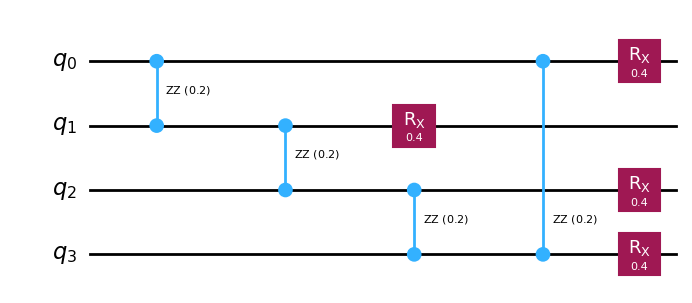

In [11]:
# We can now sketch the circuit of a single Trotter step for N = 4 spins
# We choose the natural encoding where |0> in a qubit corresponds to an up-spin and |1> to a down-spin

# Parameters
N = 4
J = 1
h = 2
dt = 0.1

# Quantum Circuit
qc = QuantumCircuit(4)

# Trotter Hz step
for index in range(N-1):
    qc.rzz(2*J*dt, index, index+1)

# Periodic Boundary Conditions
qc.rzz(2*J*dt, N-1, 0)

# Trotter Hx step
for index in range(N):
    qc.rx(2*h*dt, index)

# Sketch!
qc.draw("mpl")

We can take a look at this circuit and reason that we should be able to reduce the circuit depth by changing the order in which we apply the RZZ gates, which should not change the outcome of the circuit because it corresponds to just changing the order of the terms in the Hamiltonian!

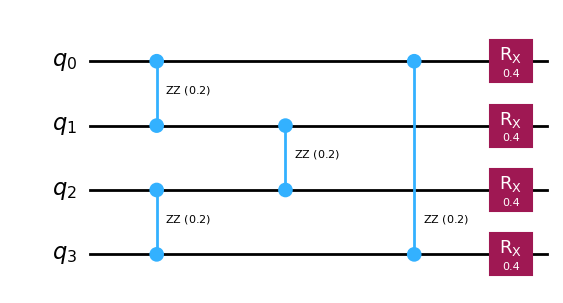

In [12]:
# Quantum Circuit
qc = QuantumCircuit(4)

# Trotter Hz step
for index in list(range(0, N-1, 2)) + list(range(1, N-1, 2)):
    qc.rzz(2*J*dt, index, index+1)

# Periodic Boundary Conditions
qc.rzz(2*J*dt, N-1, 0)

# Trotter Hx step
for index in range(N):
    qc.rx(2*h*dt, index)

# Sketch!
qc.draw("mpl")

# Problem 2: Implementation in Qiskit

We now write a function that implements a Trotter step for this system, for any parameters.

In [13]:
def add_Trotter_step(qc: QuantumCircuit, J: float, h: float, dt: float, N: int = -1) -> None:
    """
        Add the circuit corresponding to a Trotter step to the end of `qc`.
    """

    # If N is specified, add gates to first N qubits of qc
    # Otherwise, set N equal to the number of qubits of qc
    if N == -1:
        N = qc.num_qubits
    
    # Trotter Hz step
    for index in list(range(0, N-1, 2)) + list(range(1, N-1, 2)):
        qc.rzz(2*J*dt, index, index+1)
    
    # Periodic Boundary Conditions
    if N > 1:
        qc.rzz(2*J*dt, N-1, 0)

    # Trotter Hx step
    for index in range(N):
        qc.rx(2*h*dt, index)

In [14]:
def build_Trotter_simulation(initial_state: Statevector, J: float, h: float, tmax: float, r: int) -> QuantumCircuit:
    """
        Build a circuit that implements the first-order Trotter-Suzuki formula above for a time `tmax` with `r` steps.
    """

    # Compute dt
    dt = tmax / r

    # Infer number of qubits
    N = initial_state.num_qubits
    if N == None:
        raise ValueError("Invalid initial state")

    # Create the base circuit
    qc = QuantumCircuit(N)

    # Prepare the initial state
    qc.initialize(initial_state, range(N))

    # Add r steps to it
    for _ in range(r):
        add_Trotter_step(qc, J, h, dt)
    
    # Return the circuit
    return qc

In [15]:
def run_Trotter_simulation(initial_state: Statevector, J: float, h: float, tmax: float, r: int, meas: str = "Z") -> tuple[list[float], list[Statevector]]:
    """
        Run a simulation with the desired parameters and return a list with the corresponding timestamps and probabilities at each of those times, return results measured in the basis `meas`.
    """

    # Compute dt
    dt = tmax / r

    # Infer number of qubits
    N = initial_state.num_qubits
    if N == None:
        raise ValueError("Invalid initial state")

    # Create the base circuit
    qc = QuantumCircuit(N)

    # Prepare the initial state
    qc.initialize(initial_state, range(N))

    # Make the measurement in the desired basis
    if meas == "Z":
        qc_measure = qc.copy()
    elif meas == "X":
        qc_measure = qc.copy()
        qc_measure.h(range(N))

    # Initialize outputs
    tt = [0.0]
    ss = [Statevector(qc_measure)]

    # At each step, get the probabilities
    for _ in range(r):

        # Add the circuit that does this step
        add_Trotter_step(qc, J, h, dt)

        if meas == "Z":
            qc_measure = qc.copy()
        elif meas == "X":
            qc_measure = qc.copy()
            qc_measure.h(range(N))

        tt += [tt[-1] + dt]
        ss += [Statevector(qc_measure)]
    
    return tt, ss

## No Coupling

We will start by simulating a simplified version of our system to check that our code works correctly!

In [16]:
# Parameters
J = 0
h = 1
tmax = 4
r = 100

### Eigenstates

If we have no coupling, then the eigenstates of our system are given by the tensor product of single particle eigenstates where the spin is aligned or anti-aligned with field direction.

In [17]:
# Initial state
state_in = Statevector.from_label("+")

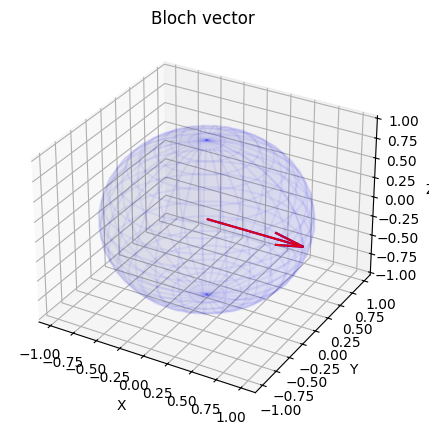

In [18]:
# Run the simulation
tt, ss = run_Trotter_simulation(state_in, J, h, tmax, r, meas="Z")

# View the results
plot_bloch(ss, "Bloch vector")

### Precession

We can see that if we are not in an eigenstate the system will precess around the direction of the magnetic field!

In [19]:
# Initial state (change this to check various states)
state_in = Statevector([np.sqrt(0.70), np.sqrt(0.30)])

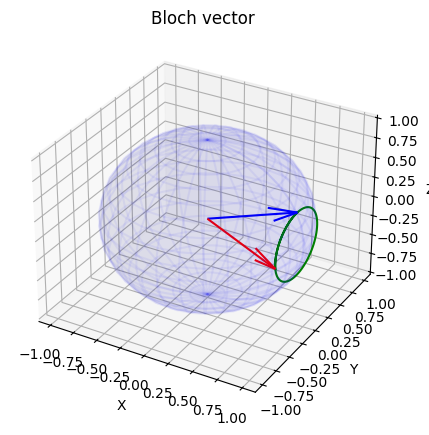

In [20]:
# Run the simulation
tt, ss = run_Trotter_simulation(state_in, J, h, tmax, r, meas="Z")

# View the results
plot_bloch(ss, "Bloch vector")

## Full System

Now we are going to test our code for the full system.

In [21]:
# Parameters
J = 2
h = 0.5
tmax = 2
r = 100

N = 3

### Eigenstates

First we will check that we have the correct behavior for the system's eigenstates, that is, the time-evolution of an eigenstate of the system merely changes its global phase, hence measurement outcomes should be constant.

We can compute the eigenstates by building the full Hamiltonian and then diagonalizing it.

In [22]:
def hamiltonian(N: int, J: float, h: float) -> np.ndarray:
    """
        Build the Hamiltonian for our system with the specified parameters
    """

    # Identity matrix
    id = np.eye(2)

    # Define Pauli matrices
    sx = np.array([[0, 1], [1, 0]])
    sz = np.array([[1, 0], [0, -1]])
    
    # Build Hamiltonian
    ham = np.zeros((2**N, 2**N))

    # Apply ZZ gates
    for index in range(N-1):
        operator = np.kron(sz, sz)

        for _ in range(index):
            operator = np.kron(id, operator)
        
        for _ in range(index+2, N):
            operator = np.kron(operator, id)
        
        ham += J * operator
    
    # Periodic Boundary Conditions
    operator = sz.copy()
    for _ in range(N-2):
        operator = np.kron(operator, id)
    operator = np.kron(operator, sz)
    
    ham += J * operator

    # Apply X gates
    for index in range(N):
        operator = sx.copy()

        for _ in range(index):
            operator = np.kron(id, operator)
        
        for _ in range(index+1, N):
            operator = np.kron(operator, id)
            
        ham += h * operator

    return ham

In [23]:
# Get the Hamiltonian
ham = hamiltonian(N, J, h)

# Get the eigenvectors
vals, vecs = np.linalg.eigh(ham)

# Initial state (change this to check various states)
state_index = 3
state_in = Statevector(vecs[:, state_index])

# Get number of qubits
N = state_in.num_qubits if state_in.num_qubits is not None else -1

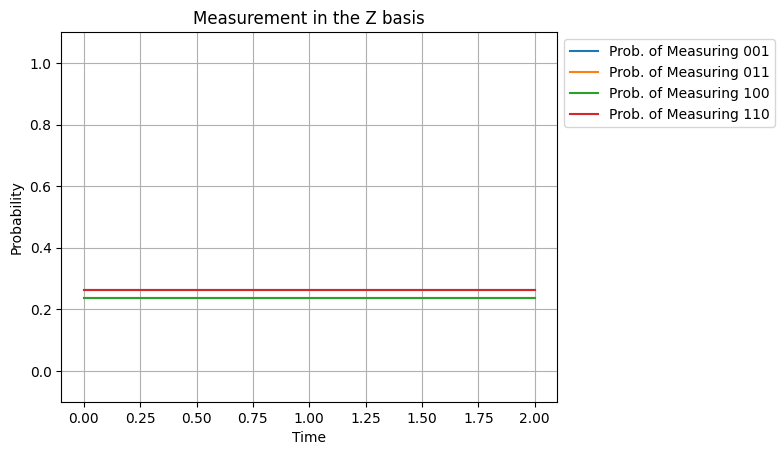

Measurement outcomes not shown have approximately zero probability of being seen.

Probability curves for 001 and 110 overlap!
Probability curves for 011 and 100 overlap!


In [24]:
# Run the simulation
tt, ss = run_Trotter_simulation(state_in, J, h, tmax, r)

# Parse the results
pp = get_probabilities(ss)

# Plot
plot_probabilities(tt, pp, N, "Measurement in the Z basis")

### Comparison with Qiskit's `TrotterQRTE`

As a final test, we can compare our time evolution with Qiskit's implementation of Trotterization.

Using correct Hamiltonian: Yes


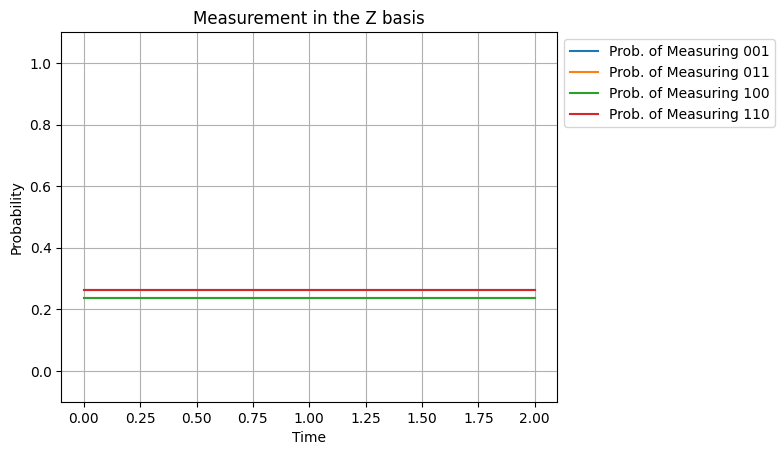

Measurement outcomes not shown have approximately zero probability of being seen.

Probability curves for 001 and 110 overlap!
Probability curves for 011 and 100 overlap!


In [25]:
# Get the Hamiltonian
ham = hamiltonian(N, J, h)

# Get appropriate pauli matrices
llN, ppN, pauliN = pauliinv(2**N)

# Decompose the Hamiltonian into Pauli matrices
coeffs = pauliN @ ham.flatten()

# Create SparsePauliOp
ham_pauli = SparsePauliOp.from_list(list(zip(llN, coeffs)))

# Make sure our Pauli Operator matches the real Hamiltonian
print(f"Using correct Hamiltonian: {'Yes' if np.allclose(ham_pauli.to_matrix(), np.array(ham)) else 'No'}")

# Initialize TrotterQRTE object
trotter = TrotterQRTE()

# Compute dt
dt = tmax / r

# Get the states at each time step
# We do it like this because TrotterQRTE uses the first-order formula with one step
ss = [state_in]
for _ in range(r):
    problem = TimeEvolutionProblem(ham_pauli, initial_state=ss[-1], time=dt)

    # Do the time evolution
    result = trotter.evolve(problem)

    # Get the result
    ss += [Statevector(result.evolved_state)]

# Parse the results
pp = get_probabilities(ss)

# Plot
plot_probabilities(tt, pp, N, "Measurement in the Z basis")

## Validity of the Approximation

Now that we are sure our code does simulate the system correctly and that we have computed the eigenstates for our Hamiltonian, we can study the error introduced by the first-order Trotterized formula.

In [26]:
# Parameters
J = 2
h = 0.5
tmax = 10
rmax = 61

N = 3

### Qualitative Study

First we do a quick qualitative study, and show that this source of error is significant and **must** be taken into account, as it can give clerly wrong results.

In order to show that, we evolve an eigenstate for various values of $r$ and plot the final probabilities as a function of the number of steps.

In [27]:
# Choose an initial state
state_in = Statevector.from_label("+++")

# Get number of qubits
N = state_in.num_qubits if state_in.num_qubits is not None else -1

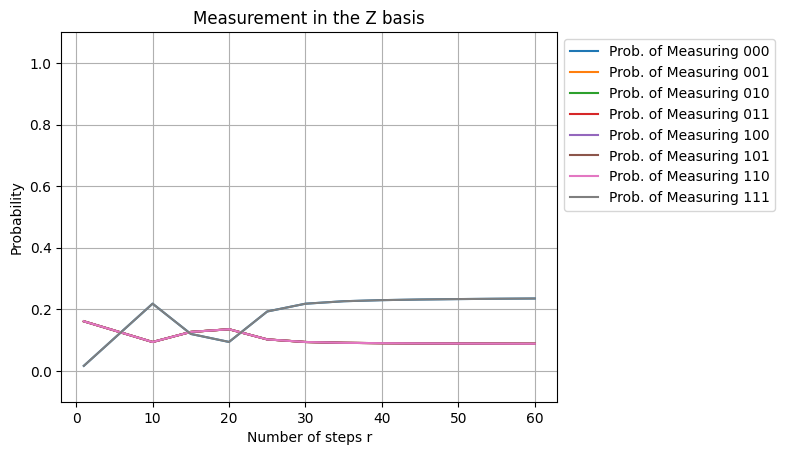

Probability curves for 000 and 111 overlap!
Probability curves for 001 and 010 overlap!
Probability curves for 001 and 011 overlap!
Probability curves for 001 and 100 overlap!
Probability curves for 001 and 101 overlap!
Probability curves for 001 and 110 overlap!


In [28]:
# Number of steps to use
rr = [1] + list(np.arange(10, rmax, 5))
pp = [[] for _ in range(2**N)]
for r in rr:
    # Run the simulation
    tt, ss = run_Trotter_simulation(state_in, J, h, tmax, r)

    # Parse the results
    probs = get_probabilities([ss[-1]])
    for index, item in enumerate(probs):
        pp[index] += [item]

# Plot
plot_probabilities(rr, pp, N, "Measurement in the Z basis", xlabel="Number of steps r")

### Quantitative Study

We can see that for a large enough number of steps our algorithm seems to converge towards a value for the probability of measuring each state after the elapsed time.

Looking at our proof of the Trotter-Suzuki formula, we se that the first term of the BCH formula that we ignore has a pre-factor of $1/n$ hence we can reasonably consider that this method has an error that is inversely proportional to the number of steps that we have taken.

This means that we can do the following calculation, where $s_r$ is the state vector obtained from our first-order Trotterization for some number $r$ of steps, with associated error $\varepsilon_r$ compared to the exact evolved state:
\begin{align*}
s_r + \varepsilon_{r} = s_{m \cdot r} + \varepsilon_{m \cdot r} &\hArr s_r - s_{m \cdot r} = \varepsilon_{m \cdot r} - \varepsilon_{r}
\\\\
&\hArr s_r - s_{m \cdot r} = \varepsilon_{m \cdot r}\left(1 - m\right)
\end{align*}

Where in the last step we considered that the error of taking $r$ steps is $m$ times larger then the error of taking $mr$ steps, which allows us to estimate the error using the following formula:
\begin{align*}
|\varepsilon_{m \cdot r}| &= \left|\frac{s_r - s_{m \cdot r}}{1-m}\right|
\end{align*}

Therefore, we can create a simple adaptive simulation by reasoning as follows:
- We simulate with some number of steps.
- We increase the number of steps by a multiplicative factor.
- We compare their output statevectors, and if the error is below the threashold, then the simulation has the desired precision.

In [29]:
def adaptive_Trotter_simulation(initial_state: Statevector, J: float, h: float, tmax: float, rstart: int, meas: str = "Z", rmult: float = 1.5, eps: float = 0.2) -> tuple[list[float], list[Statevector]]:
    """
        Run an adaptive simulation, starting with `rstart` steps and increasing by `rmult` until the error is below the desired threshold `eps`.
    """

    # First iteration
    r = rstart
    error = eps + 1

    # Infer number of qubits
    N = initial_state.num_qubits
    if N == None:
        raise ValueError("Invalid initial state")

    # Initialize outputs
    final_prev = None

    # First we do a loop where we only compute the final state
    r = rstart
    while True:

        # Compute dt
        dt = tmax / r

        # Create the base circuit
        qc = QuantumCircuit(N)

        # Prepare the initial state
        qc.initialize(initial_state, range(N))

        # Add r steps of size dt each
        for _ in range(r):

            # Add the circuit that does this step
            add_Trotter_step(qc, J, h, dt)

        # Get the final result
        if meas == "Z":
            qc_measure = qc.copy()
        elif meas == "X":
            qc_measure = qc.copy()
            qc_measure.h(range(N))

        # Current output
        final_now = Statevector(qc_measure)

        # Compute error
        if final_prev:
            error = np.linalg.norm(final_prev - final_now) / np.abs(1-rmult)

        # Compare with threashold
        if error < eps:
            break

        else:
            # Prepare next iteration
            r = int(r * rmult)
            final_prev = final_now.copy()


    # Compute new dt
    dt = tmax / r

    # Create the base circuit
    qc = QuantumCircuit(N)

    # Prepare the initial state
    qc.initialize(initial_state, range(N))

    # Make the measurement in the desired basis
    if meas == "Z":
        qc_measure = qc.copy()
    elif meas == "X":
        qc_measure = qc.copy()
        qc_measure.h(range(N))

    # Initialize outputs
    tt = [0.0]
    ss = [Statevector(qc_measure)]

    # At each step, get the probabilities
    for _ in range(r):

        # Add the circuit that does this step
        add_Trotter_step(qc, J, h, dt)

        if meas == "Z":
            qc_measure = qc.copy()
        elif meas == "X":
            qc_measure = qc.copy()
            qc_measure.h(range(N))

        tt += [tt[-1] + dt]
        ss += [Statevector(qc_measure)]
    
    return tt, ss

In [30]:
# Choose an initial state
state_in = Statevector.from_label("+++")

# Get number of qubits
N = state_in.num_qubits if state_in.num_qubits is not None else -1

The final simulation was done with r = 109


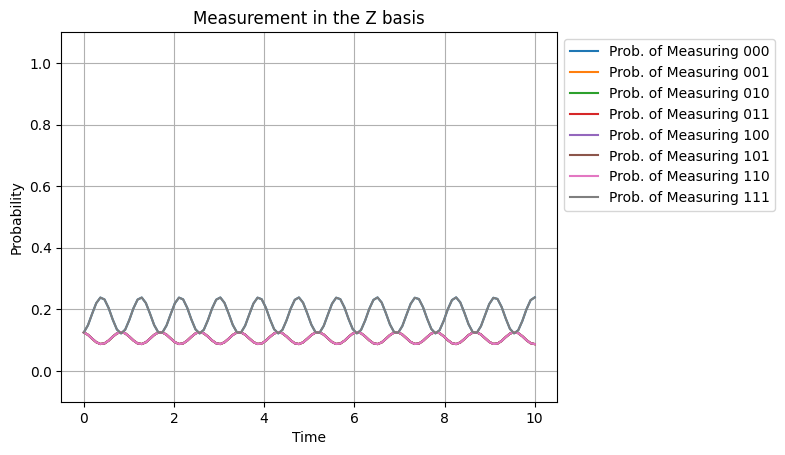

Probability curves for 000 and 111 overlap!
Probability curves for 001 and 010 overlap!
Probability curves for 001 and 011 overlap!
Probability curves for 001 and 100 overlap!
Probability curves for 001 and 101 overlap!
Probability curves for 001 and 110 overlap!


In [31]:
# Run the simulation
tt, ss = adaptive_Trotter_simulation(state_in, J, h, tmax, 10)

# Final value of r that we used
print(f"The final simulation was done with r = {len(tt) - 1}")

# Parse the results
pp = get_probabilities(ss)

# Plot
plot_probabilities(tt, pp, N, "Measurement in the Z basis")

# Problem 3: Simulations

## Exploring Parameter Space

First we explore how the system behaves for various sets of parameters and initial states, with fixed $N$.

We can reduce the volume of parameter space that we have to explore by reasoning as follows:
- If we scale both $J$ and $h$ by the same amount then we just scale the energy of the system, and looking at the evolution operator this just corresponds to a change in time scale.

- Therefore, the physics of the problem is defined by the sign of $J$ (ferro or antiferromagnetic coupling) and the ratio $h/J$ (strength of the transverse field)

This means we can explore all physically distinct parameters by doing the following:
- Set $h = 1$ and $J = 0$.
- Set $h = 0$ and $J = \pm1$.
- Fix $h = 1$ and vary $J$.

### No Coupling

We saw above that if we don't have coupling then the single spin system will just precess around the magnetic field.

The many spin system introduces no new physics given that all spins are independent, hence the analysis we did above fully explored the dynamics of uncoupled spins in a magnetic field.

### Ferromagnetic Coupling

Ferromagnetic coupling corresponds to $J < 0$ as in that case energy is reduced if neighboring spins are aligned.

In [32]:
# Parameters
J = -2
tmax = 2
r = 100

N = 4

We can check that without an externally applied field the ground state is ferromagnetic!

In [33]:
# First we take a look at the ground state to make sure it is ferromagnetic
h = 0
ham = hamiltonian(N, J, h)

# Get the eigenvectors
vals, vecs = np.linalg.eigh(ham)

# Find minimum eigenvalue
val_mini = np.min(vals)

# Show all ground states
print(f"Ground state has energy {val_mini:.3f}.\n")
print(f"Lowest energy subspace if spanned by the following states:")
for index, energy in enumerate(vals):
    # Check it is a ground state
    if energy == val_mini:

        # Draw ground state
        state = Statevector(vecs[:, index])
        print(str(state.draw("latex_source"))[2:-7])

Ground state has energy -8.000.

Lowest energy subspace if spanned by the following states:
0000
1111


Now we can see the dynamics of the system if we initialize it in the ferromagnetic ground state.

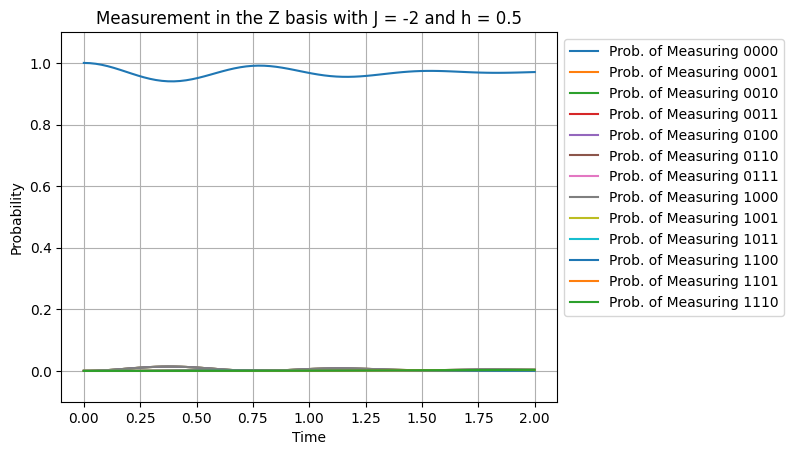

Measurement outcomes not shown have approximately zero probability of being seen.

Probability curves for 0001 and 0010 overlap!
Probability curves for 0001 and 0100 overlap!
Probability curves for 0001 and 1000 overlap!
Probability curves for 0011 and 0110 overlap!
Probability curves for 0011 and 1001 overlap!
Probability curves for 0011 and 1100 overlap!
Probability curves for 0111 and 1011 overlap!
Probability curves for 0111 and 1101 overlap!
Probability curves for 0111 and 1110 overlap!


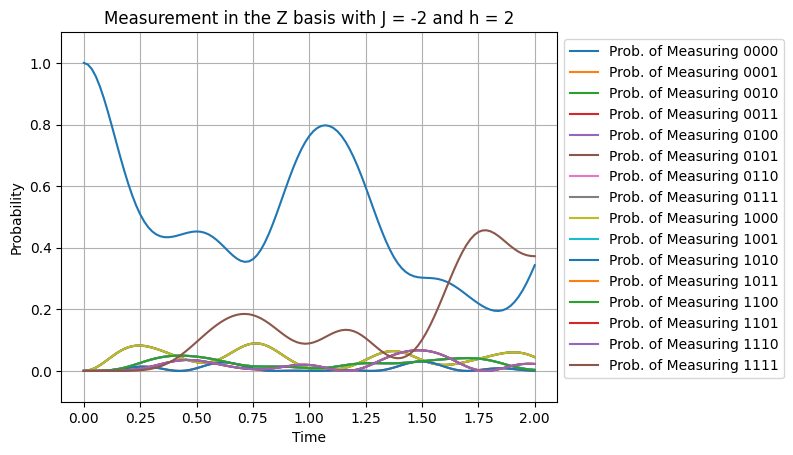

Probability curves for 0001 and 0010 overlap!
Probability curves for 0001 and 0100 overlap!
Probability curves for 0001 and 1000 overlap!
Probability curves for 0011 and 0110 overlap!
Probability curves for 0011 and 1001 overlap!
Probability curves for 0011 and 1100 overlap!
Probability curves for 0101 and 1010 overlap!
Probability curves for 0111 and 1011 overlap!
Probability curves for 0111 and 1101 overlap!
Probability curves for 0111 and 1110 overlap!


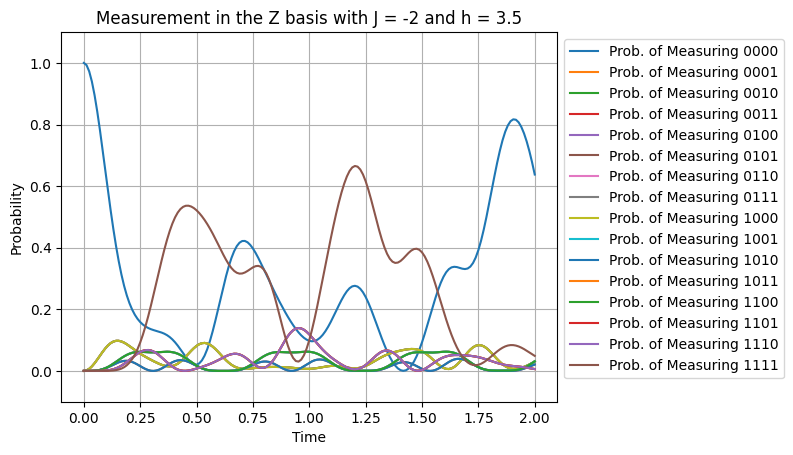

Probability curves for 0001 and 0010 overlap!
Probability curves for 0001 and 0100 overlap!
Probability curves for 0001 and 1000 overlap!
Probability curves for 0011 and 0110 overlap!
Probability curves for 0011 and 1001 overlap!
Probability curves for 0011 and 1100 overlap!
Probability curves for 0101 and 1010 overlap!
Probability curves for 0111 and 1011 overlap!
Probability curves for 0111 and 1101 overlap!
Probability curves for 0111 and 1110 overlap!


In [34]:
# Parameters
hh = [0.5, 2, 3.5]

# Choose the initial state to be the ferromangetic ground state.
state_coefficients = [0 for _ in range(2**N)]
state_coefficients[0] = 1
state_in = Statevector(state_coefficients)
for h in hh:

    # Run the simulation
    tt, ss = adaptive_Trotter_simulation(state_in, J, h, tmax, 50, eps=0.05)

    # Parse the results
    pp = get_probabilities(ss)

    # Plot
    plot_probabilities(tt, pp, N, f"Measurement in the Z basis with J = {J} and h = {h}")

We can see that, if the system starts in the ferromagnetic ground stete:

- For low field we merely get a perturbative effect during the time-evolution of the system, that is, the system is still mostly in the ferromagnetic state, with some oscilations.

- As we increase the field, we get some **switching** between the two ferromagnetic ground states, that is, the system mostly alterantes between states $|0\cdots0\rangle$ and $|1\cdots1\rangle$ with other states having small coefficients in the system's superposition. This is akin to the precession we observed for a single spin, but now occuring for the whole system.

Then, looking at which probabilities overlap, we understand that states are split according to their energy under the system's Hamiltonian:

- All states with only one spin down (only one $1$) are equaly likely.

- All states with three spins down are equaly likely.

- States with two spins down are split into to groups, one where the two down spins are next to each other and another where the two down spins are separated by up spins.

### Antiferromagnetic Coupling

We will now study antiferromangetic coupling, using a bipartite lattice (we will study frustration later).

In [35]:
# Parameters
J = +2
tmax = 2
r = 100

N = 4

We can see that the ground state is anti-ferromagnetic!

In [36]:
# First we take a look at the ground state to make sure it is ferromagnetic
h = 0
ham = hamiltonian(N, J, h)

# Get the eigenvectors
vals, vecs = np.linalg.eigh(ham)

# Find minimum eigenvalue
val_mini = np.min(vals)

# Show all ground states
print(f"Ground state has energy {val_mini:.3f}.\n")
print(f"Lowest energy subspace if spanned by the following states:")
for index, energy in enumerate(vals):
    # Check it is a ground state
    if energy == val_mini:

        # Draw ground state
        state = Statevector(vecs[:, index])
        print(str(state.draw("latex_source"))[2:-7])

Ground state has energy -8.000.

Lowest energy subspace if spanned by the following states:
0101
1010


We can do a similar simulation to the one above, starting in the anti-ferromagnetic ground state, obtaining similar results.

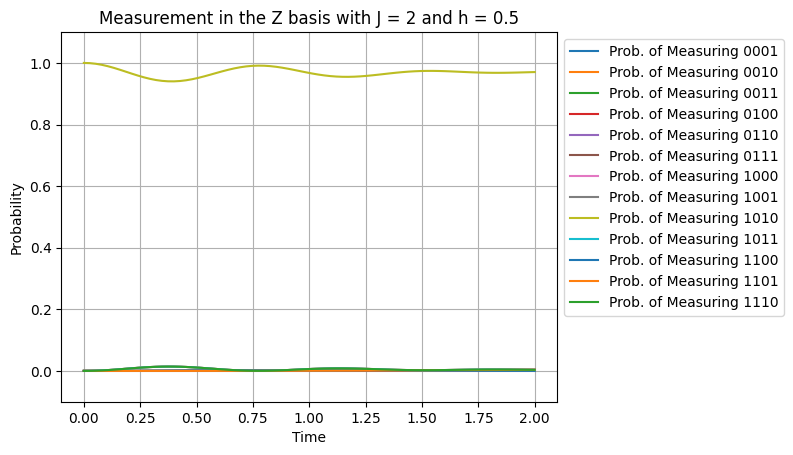

Measurement outcomes not shown have approximately zero probability of being seen.

Probability curves for 0001 and 0100 overlap!
Probability curves for 0001 and 0111 overlap!
Probability curves for 0001 and 1101 overlap!
Probability curves for 0010 and 1000 overlap!
Probability curves for 0010 and 1011 overlap!
Probability curves for 0010 and 1110 overlap!
Probability curves for 0011 and 0110 overlap!
Probability curves for 0011 and 1001 overlap!
Probability curves for 0011 and 1100 overlap!


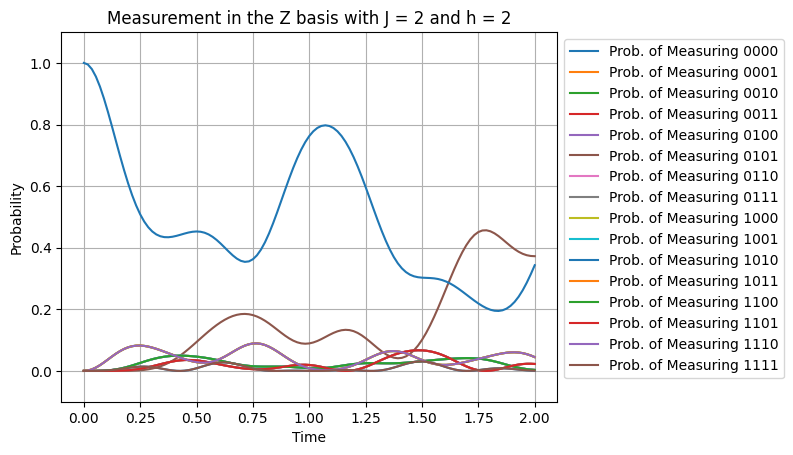

Probability curves for 0000 and 1111 overlap!
Probability curves for 0001 and 0100 overlap!
Probability curves for 0001 and 0111 overlap!
Probability curves for 0001 and 1101 overlap!
Probability curves for 0010 and 1000 overlap!
Probability curves for 0010 and 1011 overlap!
Probability curves for 0010 and 1110 overlap!
Probability curves for 0011 and 0110 overlap!
Probability curves for 0011 and 1001 overlap!
Probability curves for 0011 and 1100 overlap!


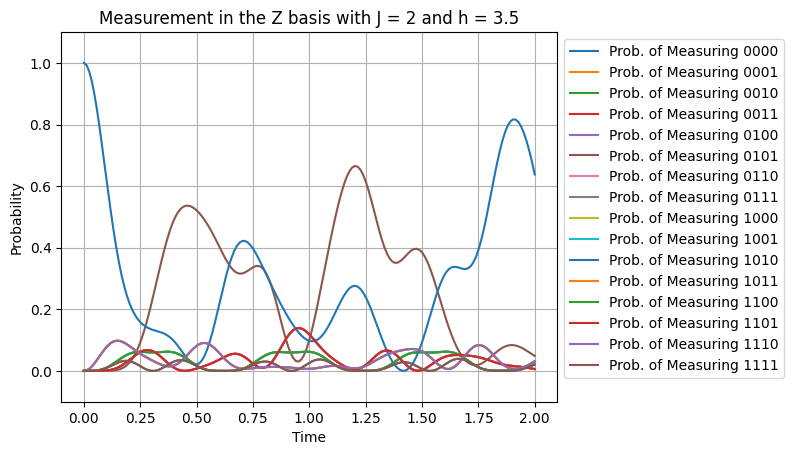

Probability curves for 0000 and 1111 overlap!
Probability curves for 0001 and 0100 overlap!
Probability curves for 0001 and 0111 overlap!
Probability curves for 0001 and 1101 overlap!
Probability curves for 0010 and 1000 overlap!
Probability curves for 0010 and 1011 overlap!
Probability curves for 0010 and 1110 overlap!
Probability curves for 0011 and 0110 overlap!
Probability curves for 0011 and 1001 overlap!
Probability curves for 0011 and 1100 overlap!


In [ ]:
# Parameters
hh = [0.5, 2, 3.5]

# Choose the initial state to be the ferromangetic ground state.
state_coefficients = [0 for _ in range(2**N)]
state_coefficients[int("1010", 2)] = 1
state_in = Statevector(state_coefficients)

for h in hh:

    # Run the simulation
    tt, ss = adaptive_Trotter_simulation(state_in, J, h, tmax, 50, eps=0.05)

    # Parse the results
    pp = get_probabilities(ss)

    # Plot
    plot_probabilities(tt, pp, N, f"Measurement in the Z basis with J = {J} and h = {h}")

We see that as we increase the transverse field the system is no longer able to relax to its ground state, due to the mixing imposed by the field!

## Dissipation Dynamics

We can introduce energy dissipation very directly into our simulation by working as follows:
- We change into the Hamilonian's eigenbasis.
- We apply thermal noise to the system, meaning it relaxes towards the $|0\cdots 0\rangle$ state, which is now the ground state of the system.
- We change back into the computational basis.

This allows us to use Qiskit's `NoiseModel` to study the relaxation of the system towards equilibrium!


This method has the disadvantage that we need to be able to diagonalize the Hamiltonian, which is only possible for small systems, but it allows us to tune the noise at will, and is physically motivated. It effectively mimics the coupling of the system to a thermal environment by driving the populations toward the ground state in the energy eigenbasis.

In short, it is a good tool for the project at hand, where we want to simulate a system with only a few qubits!

In [267]:
def disspative_Trotter_simulation(initial_state: Statevector, J: float, h: float, tmax: float, r: int, T1: float, T2: float, gate_time: float, meas: str = "Z") -> tuple[list[float], list[DensityMatrix]]:
    """
        Run a simulation with the desired parameters and return a list with the corresponding timestamps and probabilities at each of those times, return results measured in the basis `meas`.
    """

    # Compute dt
    dt = tmax / r

    # Infer number of qubits
    N = initial_state.num_qubits
    if N == None:
        raise ValueError("Invalid initial state")

    # Dissipative thermal noise (T1, T2, gate_time)
    thermal_error = thermal_relaxation_error(T1, T2, gate_time * dt)

    # Noise Model
    noise = NoiseModel()
    for index in range(N):
        noise.add_quantum_error(thermal_error, ["id"], [index])

    # Diagonalize the Hamiltonian
    # We need this to rotate our state into the eigenbasis of the Hamiltonian
    # So that our disspaition really does decrease the energy of the system
    ham = hamiltonian(N, J, h)
    _, U = np.linalg.eigh(ham)

    # Get unitary operators
    U = UnitaryGate(U, label="U")
    Udag = U.adjoint()

    # Create the base circuit
    qc = QuantumCircuit(N, N)

    # Prepare the initial state
    state_unitary = construct_unitary_from_state(list(np.sqrt(initial_state.probabilities())))
    state_unitary = Operator(state_unitary)
    qc.append(state_unitary, range(N))

    # Make the measurement in the desired basis
    if meas == "Z":
        qc_measure = qc.copy()
    elif meas == "X":
        qc_measure = qc.copy()
        qc_measure.h(range(N))

    # Initialize outputs
    tt = [0.0]
    cc = [aer_density_matrix(qc_measure, noise=noise)]

    # At each step, get the probabilities
    for _ in range(r):

        # Add the circuit that does this step
        add_Trotter_step(qc, J, h, dt, N=N)

        # Rotate into eigenbasis
        qc.append(Udag, range(N))
        
        # Let the qubits idle (introducing noise)
        qc.id(list(range(N)))

        # Rotate back into computational basis
        qc.append(U, range(N))

        if meas == "Z":
            qc_measure = qc.copy()
        elif meas == "X":
            qc_measure = qc.copy()
            qc_measure.h(range(N))

        tt += [tt[-1] + dt]
        cc += [aer_density_matrix(qc_measure, noise=noise)]
    
    return tt, cc

### Ferromagnetic Coupling

In [268]:
# Parameters
J = -2
tmax = 5
r = 70

N = 4

# Noise Parameters
T1 = 50e3
T2 = 30e3
gate = 30000

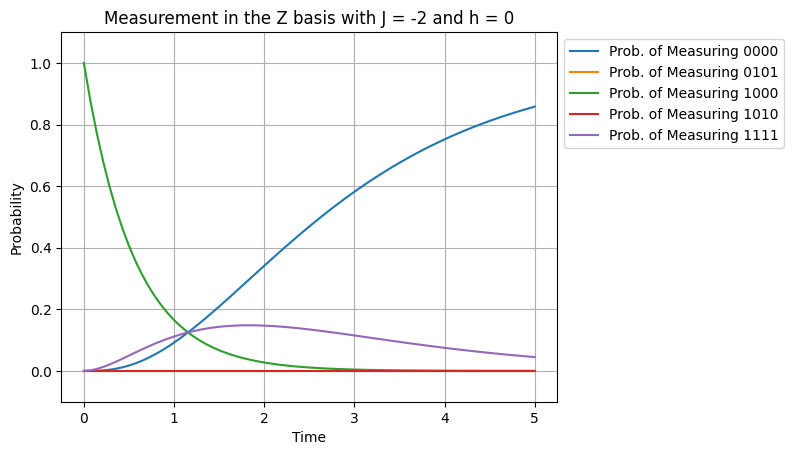

Probability curves for 0101 and 1001 overlap!
Probability curves for 0101 and 1010 overlap!
Probability curves for 0101 and 1011 overlap!
Probability curves for 0101 and 1100 overlap!
Probability curves for 0101 and 1101 overlap!
Probability curves for 0101 and 1110 overlap!


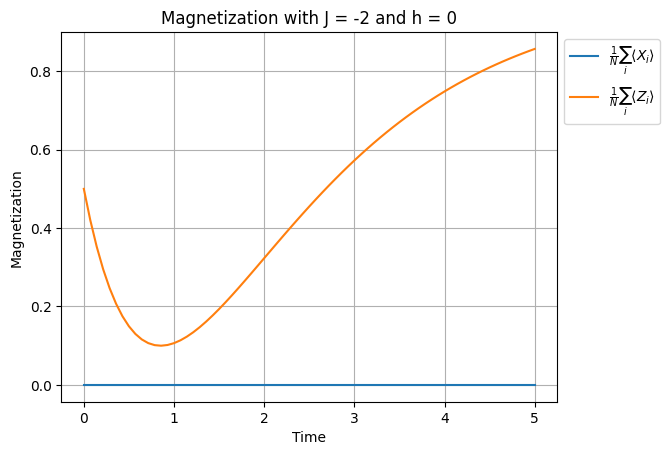

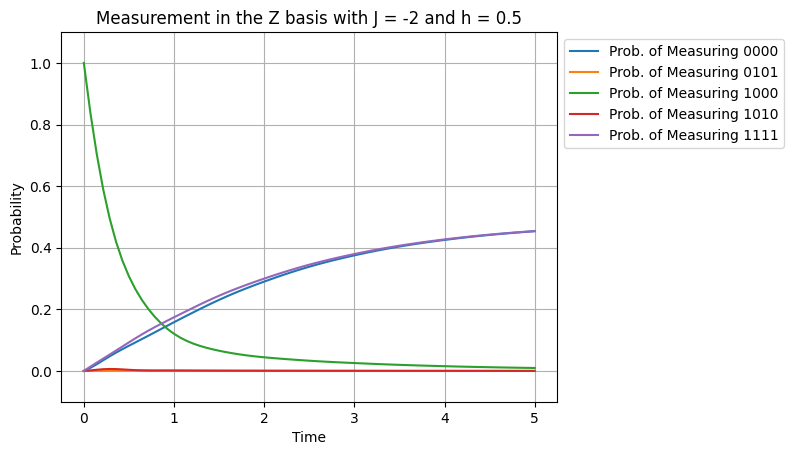

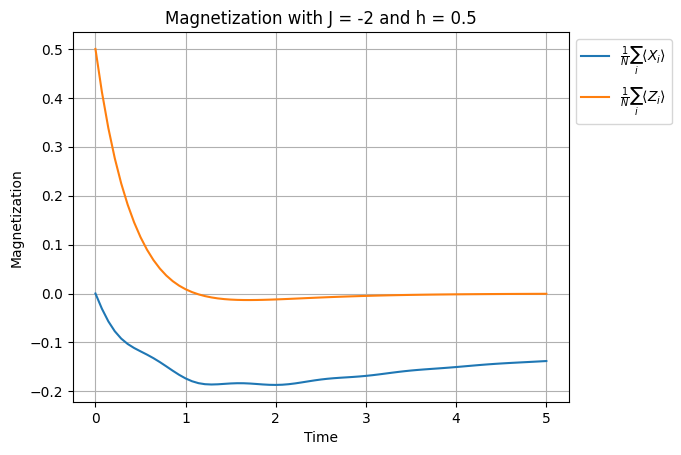

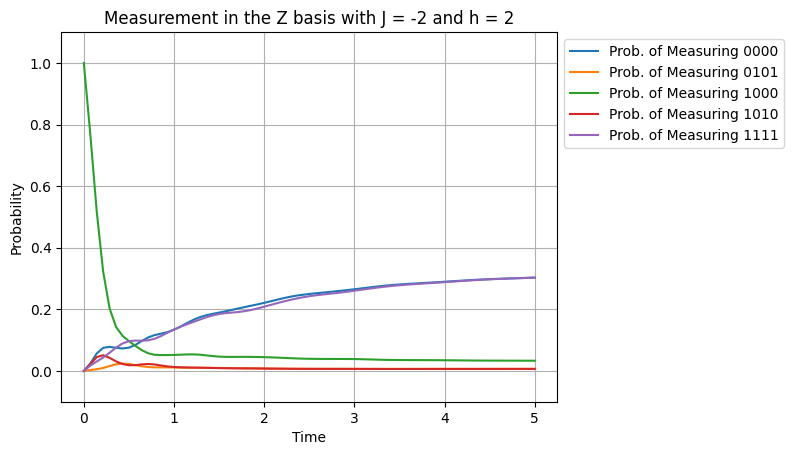

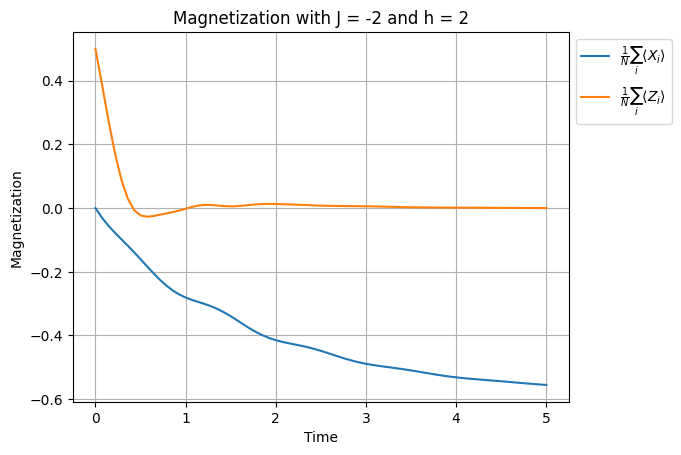

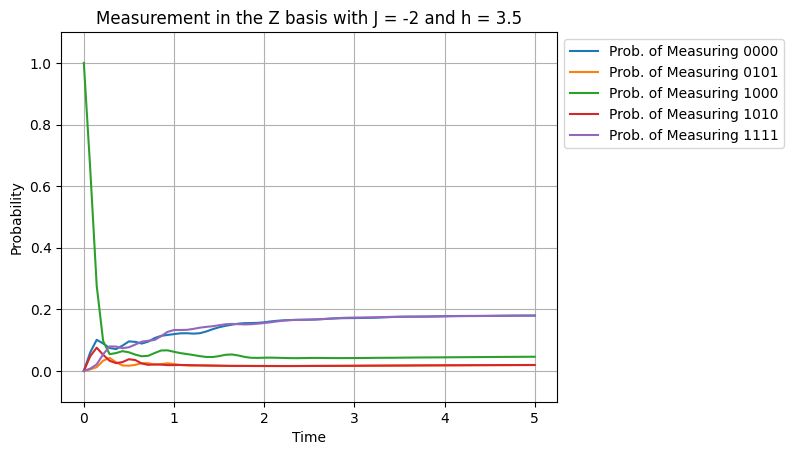

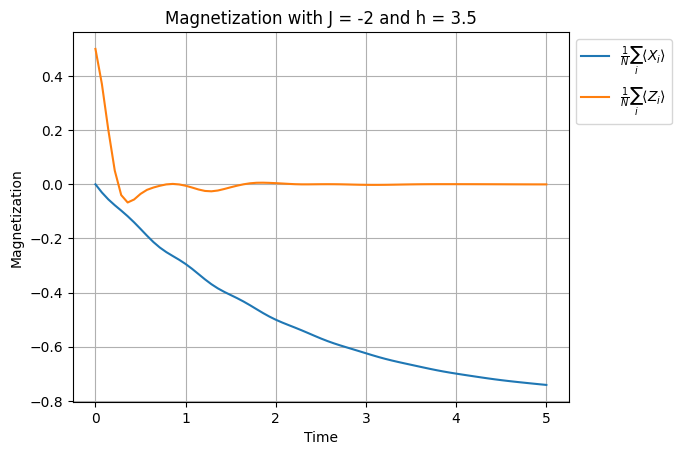

In [269]:
# Parameters
hh = [0, 0.5, 2, 3.5]

# We only study the ferromagnetic and anti-ferromagnetic states and our starting state
important = ["0000", "1010", "0101", "1111", "1000"]

# Choose the initial state to be the ferromangetic ground state.
state_coefficients = [0 for _ in range(2**N)]
state_coefficients[int("1000", 2)] = 1
state_in = Statevector(state_coefficients)
for h in hh:

    # Run the simulation
    tt, dd = disspative_Trotter_simulation(state_in, J, h, tmax, r, T1, T2, gate)

    # Parse the results
    sol_pp = [item.probabilities() for item in dd]
    pp = [[item[index] for item in sol_pp] for index in range(2**N)]

    # Plot
    plot_probabilities(tt, pp, N, f"Measurement in the Z basis with J = {J} and h = {h}", important=important)

    # Pre-compute some matrices
    x_ops = []
    y_ops = []
    z_ops = []
    qubits = range(N)
    zeros = Operator(np.zeros((2 ** N, 2 ** N)))

    for i in qubits:
        X = zeros + Pauli('X')(i)
        x_ops.append(X)

        Y = zeros + Pauli('Y')(i)
        y_ops.append(Y)

        Z = zeros + Pauli('Z')(i)
        z_ops.append(Z)
    
    # Plot magnetization
    n_times = len(tt)
    x_data = np.zeros((N, n_times))
    z_data = np.zeros((N, n_times))
    x_mean = np.zeros((n_times,))
    z_mean = np.zeros((n_times,))

    for t_i, sol_t in enumerate(dd):
        for qubit, obs in enumerate(x_ops):
            x_data[qubit, t_i] = sol_t.expectation_value(obs).real
        x_mean[t_i] = np.mean(x_data[:, t_i])

        for qubit, obs in enumerate(z_ops):
            z_data[qubit, t_i] = sol_t.expectation_value(obs).real
        z_mean[t_i] = np.mean(z_data[:, t_i])

    plt.title(f"Magnetization with J = {J} and h = {h}")
    plt.plot(tt, x_mean, label = '$ \\frac{{1}}{{N}}\\sum_i \\langle X_i \\rangle$')
    plt.plot(tt, z_mean, label = '$ \\frac{{1}}{{N}}\\sum_i \\langle Z_i \\rangle$')
    plt.xlabel("Time")
    plt.ylabel("Magnetization")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()

We see that for ferromagnetic coupling there is a tendency towards fully ferromagnetic states, but only in the case where the magnetic field is small do we get an near-zero probability for all other states.

As we increase the magnetic field, we see that:
- The mixing between the different states increases.

- The magneization along $Z$ goes to zero, due to the superposition between opposite-spin ground states.

- The magnetization along $X$ increases in the direction opposite of the field, which means that as expected the spins become anti-aligned with the magnetic field.

### Anti-Ferromagnetic Coupling

In [270]:
# Parameters
J = +2
tmax = 5
r = 70

N = 4

# Noise Parameters
T1 = 50e3
T2 = 30e3
gate = 30000

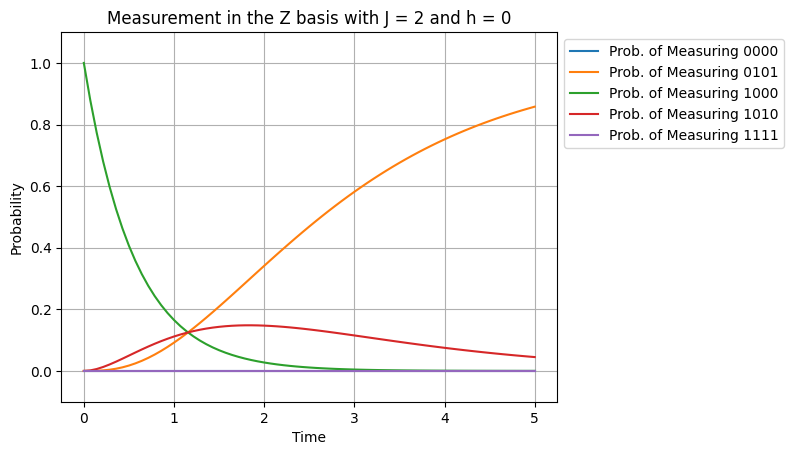

Probability curves for 0000 and 0001 overlap!
Probability curves for 0000 and 1001 overlap!
Probability curves for 0000 and 1011 overlap!
Probability curves for 0000 and 1100 overlap!
Probability curves for 0000 and 1101 overlap!
Probability curves for 0000 and 1110 overlap!
Probability curves for 0000 and 1111 overlap!


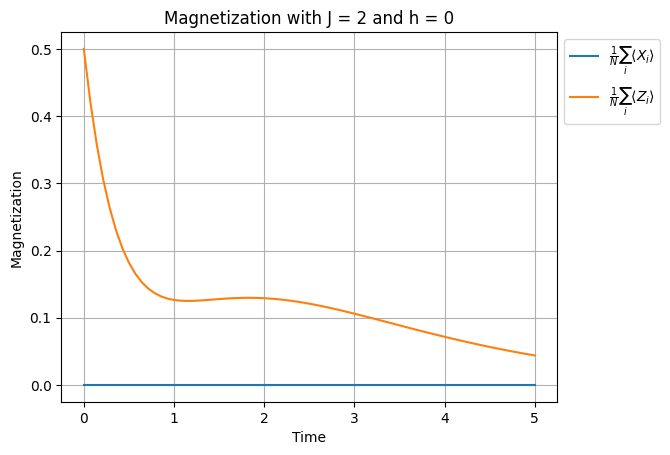

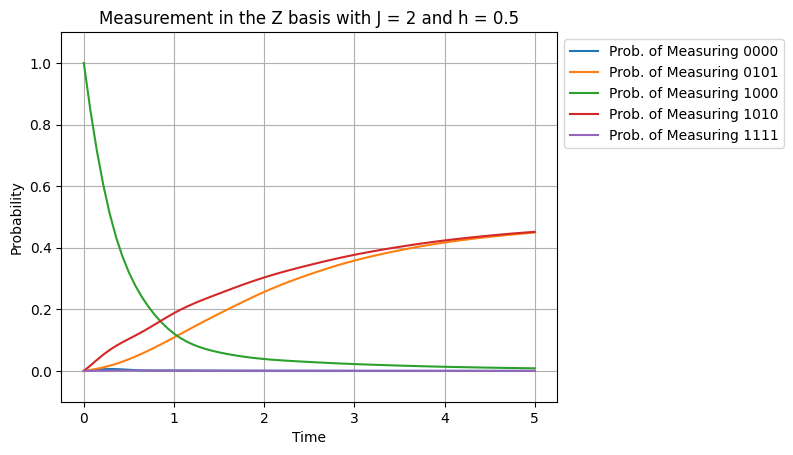

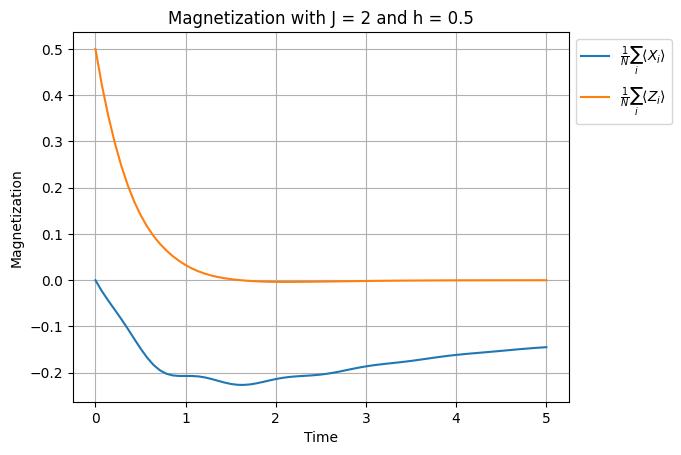

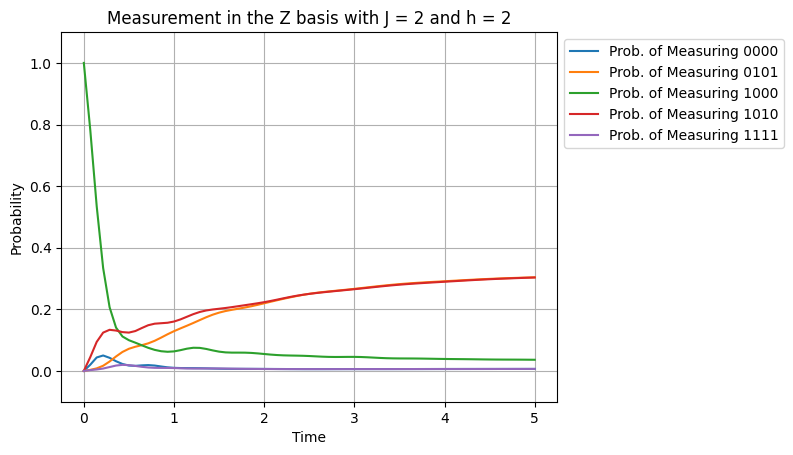

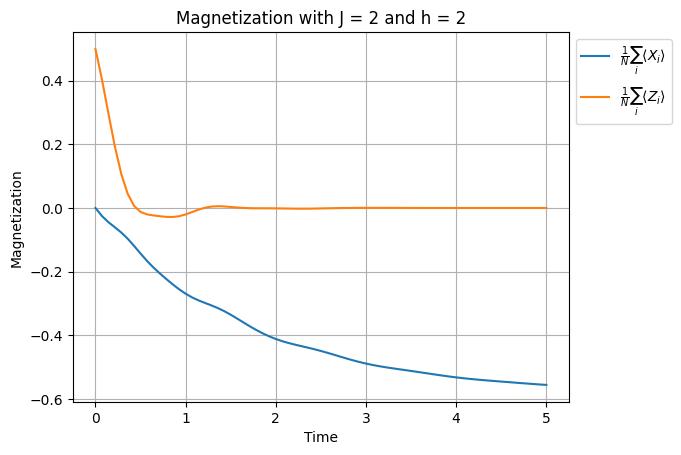

In [271]:
# Parameters
hh = [0, 0.5, 2]

# We only study the ferromagnetic and anti-ferromagnetic states and our starting state
important = ["0000", "1010", "0101", "1111", "1000"]

# Choose the initial state to be the ferromangetic ground state.
state_coefficients = [0 for _ in range(2**N)]
state_coefficients[int("1000", 2)] = 1
state_in = Statevector(state_coefficients)
for h in hh:

    # Run the simulation
    tt, dd = disspative_Trotter_simulation(state_in, J, h, tmax, r, T1, T2, gate)

    # Parse the results
    sol_pp = [item.probabilities() for item in dd]
    pp = [[item[index] for item in sol_pp] for index in range(2**N)]

    # Plot
    plot_probabilities(tt, pp, N, f"Measurement in the Z basis with J = {J} and h = {h}", important=important)

    # Pre-compute some matrices
    x_ops = []
    y_ops = []
    z_ops = []
    qubits = range(N)
    zeros = Operator(np.zeros((2 ** N, 2 ** N)))

    for i in qubits:
        X = zeros + Pauli('X')(i)
        x_ops.append(X)

        Y = zeros + Pauli('Y')(i)
        y_ops.append(Y)

        Z = zeros + Pauli('Z')(i)
        z_ops.append(Z)
    
    # Plot magnetization
    n_times = len(tt)
    x_data = np.zeros((N, n_times))
    z_data = np.zeros((N, n_times))
    x_mean = np.zeros((n_times,))
    z_mean = np.zeros((n_times,))

    for t_i, sol_t in enumerate(dd):
        for qubit, obs in enumerate(x_ops):
            x_data[qubit, t_i] = sol_t.expectation_value(obs).real
        x_mean[t_i] = np.mean(x_data[:, t_i])

        for qubit, obs in enumerate(z_ops):
            z_data[qubit, t_i] = sol_t.expectation_value(obs).real
        z_mean[t_i] = np.mean(z_data[:, t_i])

    plt.title(f"Magnetization with J = {J} and h = {h}")
    plt.plot(tt, x_mean, label = '$ \\frac{{1}}{{N}}\\sum_i \\langle X_i \\rangle$')
    plt.plot(tt, z_mean, label = '$ \\frac{{1}}{{N}}\\sum_i \\langle Z_i \\rangle$')
    plt.xlabel("Time")
    plt.ylabel("Magnetization")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()

We can see that the system moves towards the two degenerate anti-ferromagnetic states, with the overall dynamics being similar to the ferromagnetic case.

### Lindblad Dynamics

We can compare our results, obtained via quantum circuits, to a more direct solution, obtained by integrating the Lindblad equation of the system.

This method is much faster, but it is not directly based on a quantum simulation of the underlying system, hence we only look at it here as a benchmark.

In [227]:
def lindblad_simulation(initial_state: Statevector, J: float, h: float, tmax: float, gam: float, plot_magnetization: str | None = None):

    # Infer number of qubits
    N = initial_state.num_qubits
    if N == None:
        raise ValueError("Invalid initial state")
    
    # Pre-compute some matrices
    x_ops = []
    y_ops = []
    z_ops = []
    qubits = range(N)
    zeros = Operator(np.zeros((2 ** N, 2 ** N)))

    for i in qubits:
        X = zeros + Pauli('X')(i)
        x_ops.append(X)

        Y = zeros + Pauli('Y')(i)
        y_ops.append(Y)

        Z = zeros + Pauli('Z')(i)
        z_ops.append(Z)
    
    H = zeros
    for i in qubits:
        # X gates
        X = x_ops[i]
        H += h * X

        if N > 1:
            # Periodic boundary conditions
            j = (i + 1) % N

            # ZZ gates
            op = zeros + Pauli('ZZ')(i, j)
            H += J * op

    L_ops = []
    for i in qubits:
        X = x_ops[i]
        Y = y_ops[i]
        L_ops.append(np.sqrt(gam) * 0.5 * (X + 1j * Y))

    solver = Solver(static_hamiltonian=H, static_dissipators=L_ops)

    # A density matrix with all qubits in ground state
    y0 = DensityMatrix(initial_state)

    # Times to evaluate the system's state at
    tt = np.linspace(0, tmax, r+1)

    # Solution of the Lindblad equation
    sol = solver.solve(t_span=[0, tmax], y0=y0, t_eval=tt)

    if plot_magnetization:
        n_times = len(sol.y)
        x_data = np.zeros((N, n_times))
        y_data = np.zeros((N, n_times))
        z_data = np.zeros((N, n_times))
        x_mean = np.zeros((n_times,))
        y_mean = np.zeros((n_times,))
        z_mean = np.zeros((n_times,))

        for t_i, sol_t in enumerate(sol.y):
            for qubit, obs in enumerate(x_ops):
                x_data[qubit, t_i] = sol_t.expectation_value(obs).real
            x_mean[t_i] = np.mean(x_data[:, t_i])

            for qubit, obs in enumerate(y_ops):
                y_data[qubit, t_i] = sol_t.expectation_value(obs).real
            y_mean[t_i] = np.mean(y_data[:, t_i])

            for qubit, obs in enumerate(z_ops):
                z_data[qubit, t_i] = sol_t.expectation_value(obs).real
            z_mean[t_i] = np.mean(z_data[:, t_i])

        plt.title(plot_magnetization)
        plt.plot(tt, x_mean, label = '$ N^{-1}\\sum_i \\langle X_i \\rangle$')
        plt.plot(tt, y_mean, label = '$ N^{-1}\\sum_i \\langle Y_i \\rangle$')
        plt.plot(tt, z_mean, label = '$ N^{-1}\\sum_i \\langle Z_i \\rangle$')
        plt.xlabel("Time")
        plt.ylabel("Magnetization")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid()
        plt.show()

    return sol

We can test these classical dynamics for the ferromagnetic case, and we see that it also predicts an evolution towards the equilibrium state.

In [228]:
# Parameters
J = -2
tmax = 5
r = 400
gam = 0.4

N = 4

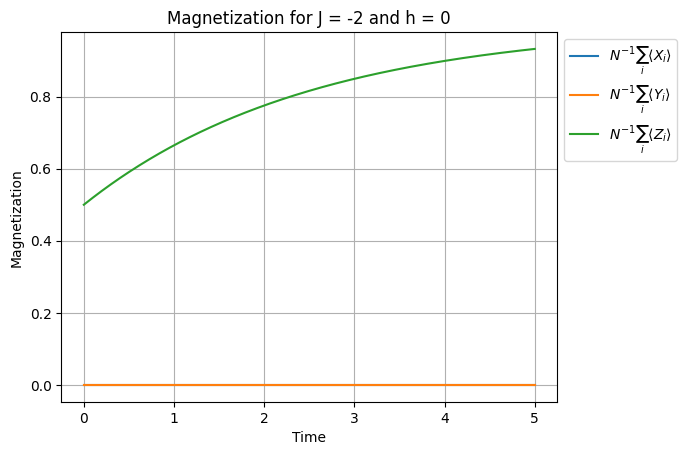

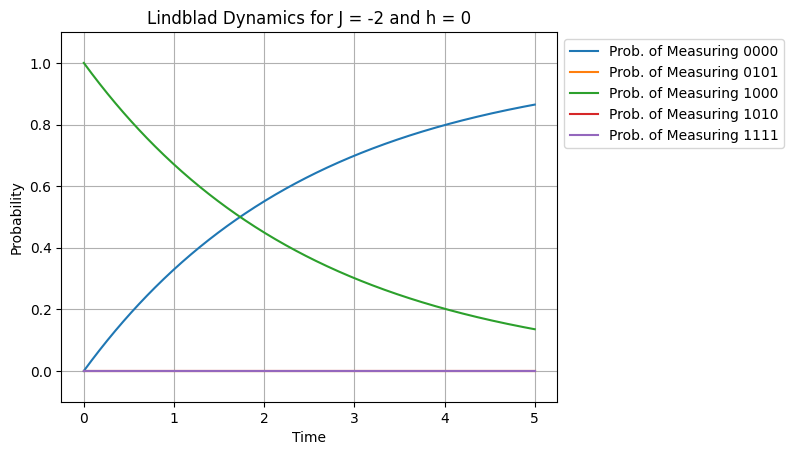

Probability curves for 0101 and 0110 overlap!
Probability curves for 0101 and 0111 overlap!
Probability curves for 0101 and 1001 overlap!
Probability curves for 0101 and 1010 overlap!
Probability curves for 0101 and 1011 overlap!
Probability curves for 0101 and 1100 overlap!
Probability curves for 0101 and 1101 overlap!
Probability curves for 0101 and 1110 overlap!
Probability curves for 0101 and 1111 overlap!


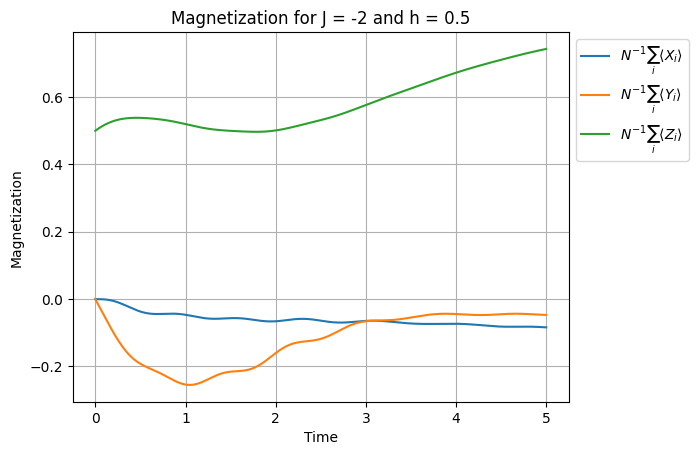

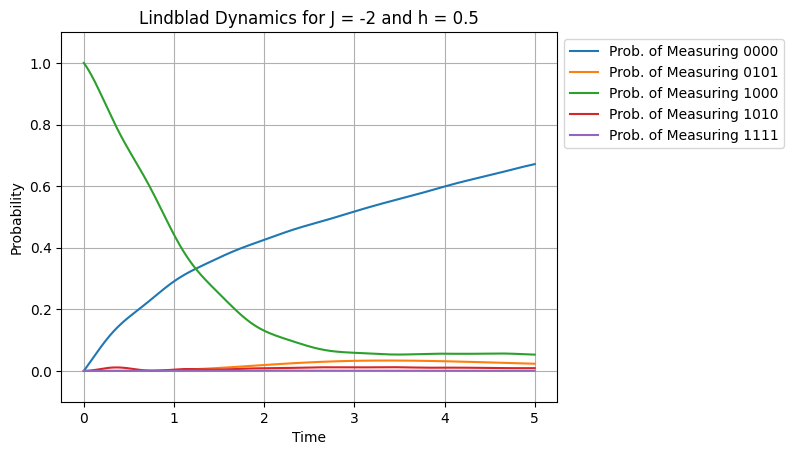

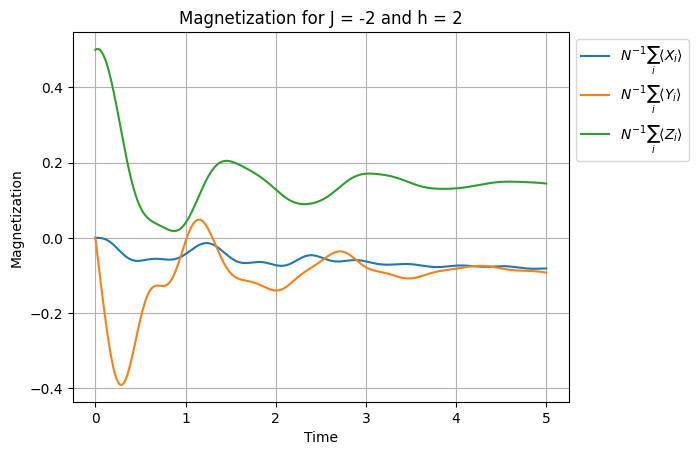

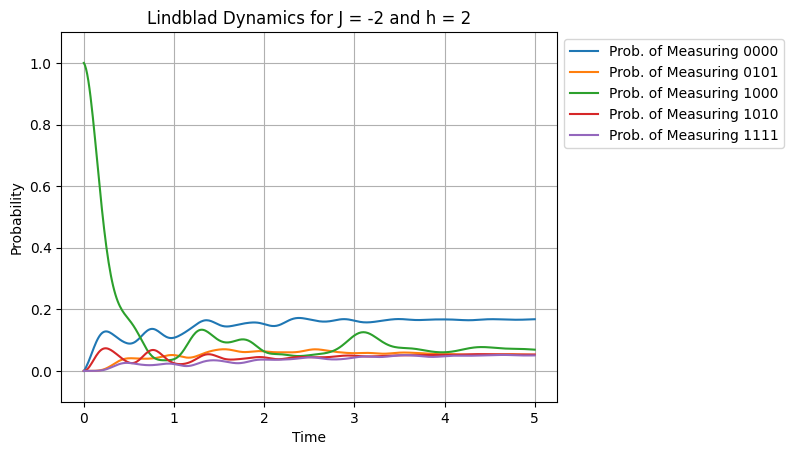

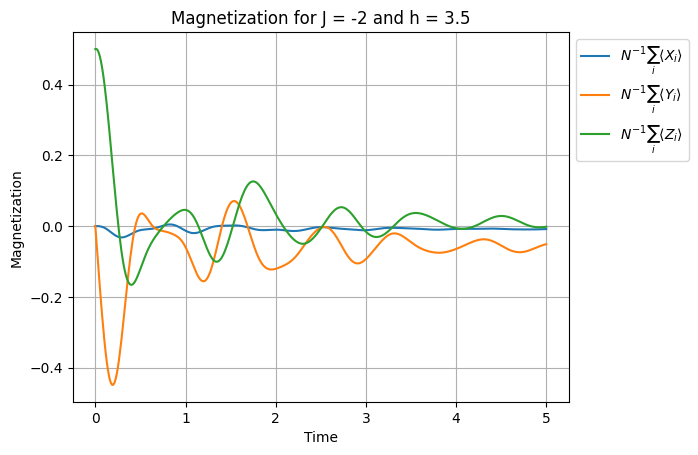

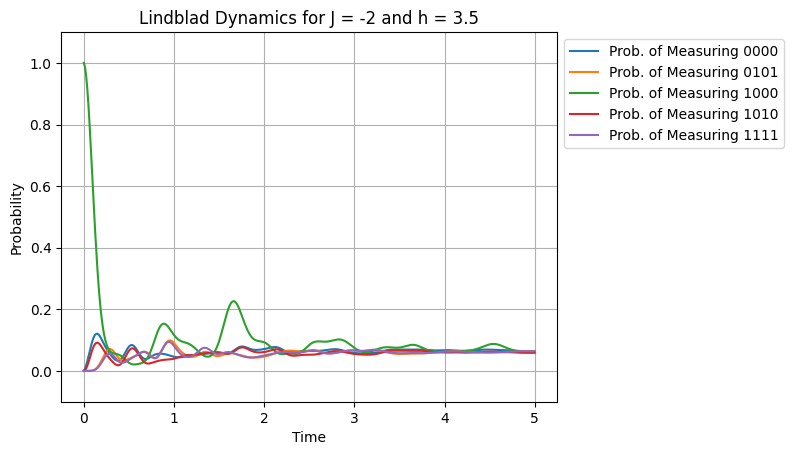

In [229]:
# Set of h to simulate
hh = [0, 0.5, 2, 3.5]

# We only study the ferromagnetic and anti-ferromagnetic states and our starting state
important = ["0000", "1010", "0101", "1111", "1000"]

# Chose initial state
state_coefficients = [0 for _ in range(2**N)]
state_coefficients[int("1000", 2)] = 1
state_in = Statevector(state_coefficients)

for h in hh:

    # Solution of the Lindblad equation
    sol = lindblad_simulation(state_in, J, h, tmax, gam, plot_magnetization=f"Magnetization for J = {J} and h = {h}")

    # Extract probabilities
    sol_pp = [item.probabilities() for item in sol.y]
    pp = [[item[index] for item in sol_pp] for index in range(2**N)]

    # Plot probabilities
    plot_probabilities(sol.t, pp, N, f"Lindblad Dynamics for J = {J} and h = {h}", important=important)